Instituição: FURB <br>
Curso: Data Science <br>
Disciplina: Chatbots <br>
Alunos: Charles Bambineti, Diego Leonardo Urban

# Trabalho Final - Análise das conversas do Chatbot de Agendamento

Levantamento de métricas das conversas do Bot de agendamento para Hospital Clínica.

O código abaixo contempla a utilização da api de comunicação do watson para extrair informações do assistente. Por meio do pandas e numpy são analisadas métricas das conversas com o Bot.

Link do código-fonte: https://github.com/diegourban/chatbot_agendamento

In [1]:
# Instalando dependências
!pip install "ibm-watson"

     |████████████████████████████████| 389kB 4.0MB/s 
     |████████████████████████████████| 204kB 19.8MB/s 
  Created wheel for ibm-watson: filename=ibm_watson-5.1.0-cp37-none-any.whl size=375439 sha256=a927ec502c73fbce5c159496b6057a2c91872fb379da70b8251f8d02f402d4dc
  Stored in directory: /root/.cache/pip/wheels/49/6d/cf/1d91261b96363da78bf9b02699fd2262e6b5dad179500690c1
  Created wheel for ibm-cloud-sdk-core: filename=ibm_cloud_sdk_core-3.10.0-cp37-none-any.whl size=60912 sha256=299e65639738633cfb0e07942d04b37efc54a4874d57202dbe372396de89b4d4
  Stored in directory: /root/.cache/pip/wheels/4a/4e/48/b02ad6dc75235fc4c0742d4e99571fe7d729e60bf365105be4
Successfully built ibm-watson ibm-cloud-sdk-core


In [2]:
# Importando dependências
import re
from datetime import time

import json
import numpy as np
import pandas as pd

import ibm_watson

from ibm_watson import AssistantV1
from ibm_cloud_sdk_core.authenticators import IAMAuthenticator

In [3]:
# Credenciais de acesso
# https://cloud.ibm.com/apidocs/assistant/assistant-v1?code=python#finding-credentials-in-the-ui
# Skills > View API Details
# wa_workspace_id = Skill ID
# wa_service_api_key = API key

#workspace Diego
#wa_workspace_id = <skill id>
#wa_service_api_key = <api key>

#workspace Charles
wa_workspace_id = <skill id>
wa_service_api_key = <api key>

# URL que corresponde a localização da instância
# https://cloud.ibm.com/apidocs/assistant/assistant-v1?code=python#service-endpoint
wa_instance_url = "https://api.us-south.assistant.watson.cloud.ibm.com"

# Autenticando da API usando Access Management (IAM)
authenticator = IAMAuthenticator(wa_service_api_key)
assistant = AssistantV1(
    version='2020-04-01', # Versionamento: https://cloud.ibm.com/apidocs/assistant/assistant-v1?code=python#versioning
    authenticator=authenticator
)
assistant.set_service_url(wa_instance_url)

In [4]:
def dump_conversations_log(wid):
  response = assistant.list_logs(
    workspace_id = wid, page_limit = 100
  ).get_result()

  list_mount_examples = []
  list_mount_intents = []
  list_mount_confidence = []
  list_mount_interaction_time = []

  cursor_regex = r".*?cursor=(.*?)&"

  logs = response['logs']
  page = response['pagination']

  total = 0
  while response:
      cont = 0

      for log in logs:
          cont += 1
          total += 1
          if log["response"]:
              lresponse = log['response']
              
              if 'input' in lresponse and 'text' in lresponse['input']:
                  if 'intents' in lresponse and lresponse['intents']:
                      list_mount_examples.append(lresponse['input']['text'].strip())
                      list_mount_intents.append(lresponse['intents'][0]['intent'])
                      list_mount_confidence.append(lresponse['intents'][0]['confidence'])
                      list_mount_interaction_time.append(log['response_timestamp'])
                  else:
                      list_mount_examples.append(lresponse['input']['text'].strip())
                      list_mount_intents.append('irrelevant')
                      list_mount_confidence.append('0')
                      list_mount_interaction_time.append(log['response_timestamp'])
      
      if not page:
          break

      cursor_res = re.search(cursor_regex, page['next_url'], re.IGNORECASE)
      cursor = None

      if cursor_res:
          cursor = cursor_res.group(1)
      if not cursor:
          break
    
      response = assistant.list_logs(workspace_id=wid, page_limit=100, cursor=cursor).get_result()
      
      logs = response['logs']
      page = response['pagination']

  df_temp = pd.DataFrame({
      'Example': list_mount_examples,
      'Intent': list_mount_intents,
      'Confidence': list_mount_confidence,
      'Interaction_Time': list_mount_interaction_time,
  }, columns=['Example','Intent','Confidence','Interaction_Time'])

  return df_temp

In [5]:
logs = dump_conversations_log(wa_workspace_id)

In [6]:
print('Quantidade de interações realizadas: {0}'.format(logs.shape[0]))

Quantidade de interações realizadas: 248


## Métrica 1 - Intenções mais questionadas

In [7]:
dist_logs = pd.DataFrame(columns=['intent', 'sizes'])

intent_blacklist = ['afirmativo','negativo', 'irrelevant']

for idx,log in logs.iterrows():
    if log['Intent'] not in intent_blacklist:
        dist_logs.loc[idx] = pd.Series({'intent': log['Intent'], 'sizes': 1})

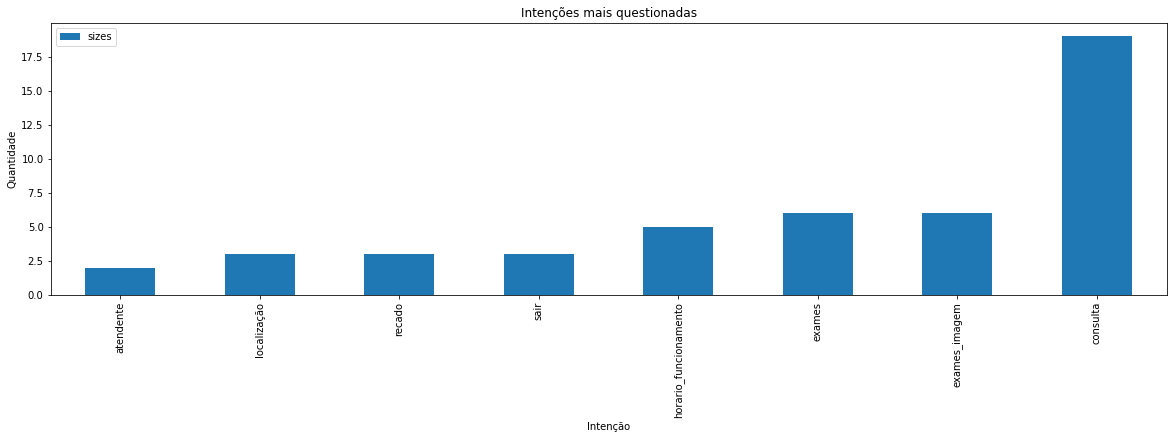

In [8]:
grouped_count = dist_logs.groupby('intent').count()

grouped = grouped_count.dropna().sort_values(by='sizes')

grouped.index.name='intent'
grouped['intent']=grouped.index

grouped.plot(kind='bar',x='intent', xlabel='Intenção', y='sizes', ylabel='Quantidade', figsize=(20,5),title='Intenções mais questionadas');

## Métrica 2 - Hora do dia de maior interação com o Bot

In [9]:
logs['Hora'] = logs['Interaction_Time'].apply(lambda x: pd.Timestamp(x, tz='America/Sao_Paulo').hour)
dist_logs = pd.DataFrame(columns=['hora', 'sizes'])

for idx,log in logs.iterrows():
  dist_logs.loc[idx] = pd.Series({'hora': log['Hora'], 'sizes': 1})

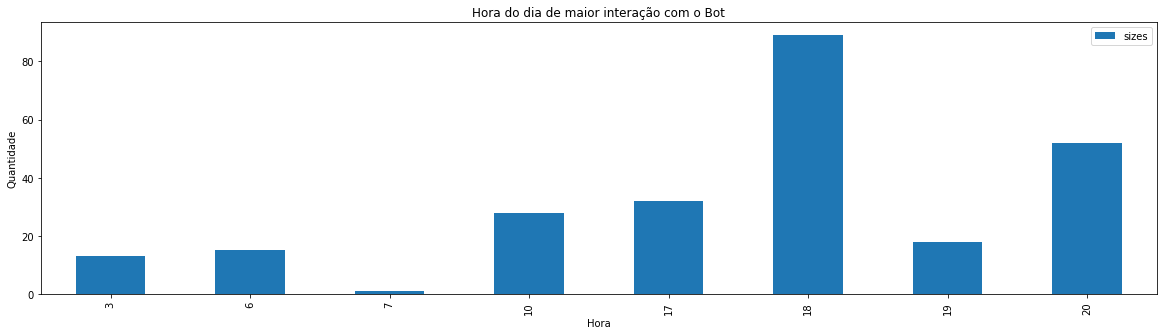

In [10]:
grouped_count = dist_logs.groupby('hora').count()
grouped = grouped_count.dropna().sort_values(by='hora')
grouped.index.name='hora'
grouped['hora']=grouped.index
grouped.plot(kind='bar',x='hora', xlabel='Hora', y='sizes', ylabel='Quantidade', figsize=(20,5),title='Hora do dia de maior interação com o Bot');

## Métrica 3 - Confiança média por intenção

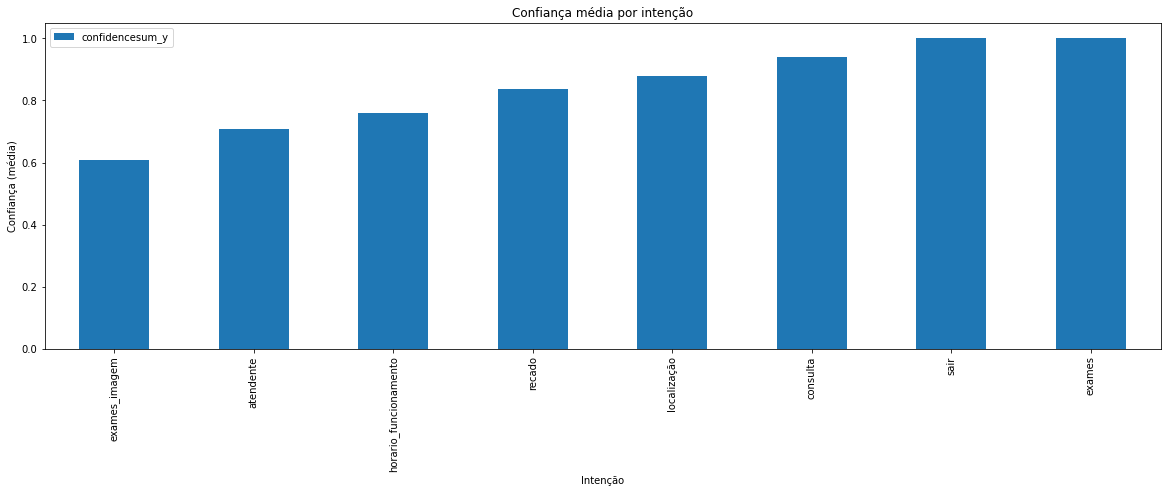

In [11]:
dist_logs = pd.DataFrame(columns=['intent', 'sizes','confidencesum'])

for idx,log in logs.iterrows():
  if log['Intent'] not in intent_blacklist:
    dist_logs.loc[idx] = pd.Series({'intent': log['Intent'], 'sizes': 1,'confidencesum': float(log['Confidence'])})

grouped_mean = dist_logs.groupby('intent').mean()
grouped_count = dist_logs.groupby('intent').count()
    
grouped_sorted = grouped_count.dropna().sort_values(by='sizes')

grouped_sorted.index.name='intent'
grouped_sorted['intent']=grouped_sorted.index

df_intersection = pd.merge(grouped_sorted, grouped_mean, left_index=True, right_index=True)
df_intersection.drop('confidencesum_x', axis=1, inplace=True)
df_intersection.sort_values(by='confidencesum_y').plot(kind='bar',x='intent',xlabel='Intenção', y='confidencesum_y', ylabel='Confiança (média)', figsize=(20,6),title='Confiança média por intenção');